In [889]:
# Imports
import numpy as np
import richdem as rd
import math
import csv
import matplotlib.pyplot as plt

from mfdfloods.gtif import openf, as_array, get_rowcol
from mfdfloods.hydrogram import gen_hydrogram
from mfdfloods.geotransform import GeoTransformFit
from mfdfloods.debug import print_exception

In [890]:
# Constants
NAN = -99
CONVERGENCE_F = 2
TRAWL_F = 2
DELTAS = np.array([
    (-1, -1), (-1, 0), (-1, +1),
    (0, -1),           (0, +1),
    (+1, -1), (+1, 0), (+1, +1)
])
COORDS = (299828.2, 4539498.5)

with open("data/iterator/hydrogram.csv") as f:
    reader = csv.reader(f, delimiter=",", quotechar='"')
    HYDROGRAM = [tuple(float(v) for v in row) for row in reader]

In [891]:
# Methods
def start_point(rc):
    slopes = get_slopes(rc)
    gateway = rc + DELTAS[slopes.argmin()]
    overcomes[rc] = True

    for delta in rc + DELTAS:
        if delta[0] != gateway[0] or delta[1] != gateway[1]:
            overcomes[tuple(delta)] = True
            
    return tuple(gateway), slopes[slopes.argmin()]
    
def get_deltas(rc):
    return np.array([
        delta for delta in rc + DELTAS
        # if tuple(delta) not in overcomes
    ])

def get_draft(flood):
    return flood / cellarea

def get_slopes(rc, src_draft=None):
    if src_draft is None:
        src_draft = drafts[rc]
        
    return np.array([
        (float(dtm[tuple(delta)]) + float(drafts[tuple(delta)])) - (dtm[rc] + src_draft)
        for delta in get_deltas(rc)
    ])

def get_slope(slopes):
    try:
        slopes = np.append(slopes, 0)
        return slopes.min() - slopes.max()
    except Exception:
        return 0

def get_volumetries(slopes):
    return cellarea * 0.25 * slopes * (1 / 3)

def get_downslopes(slopes):
    return np.where(slopes < 0, slopes * -1, 0)

def get_upslopes(slopes):
    return np.where(slopes >= 0, slopes, 0)

def get_speeds(slopes, draft, manning):
    return np.array([get_speed(draft, manning, slope) for slope in slopes])

def get_speed(draft, manning, slope):
    return max(0, (1. / manning) * math.pow(cellsize + 2 * draft, 2 / 3) * math.pow(max(0, abs(slope)) / cellsize, .5))

def del_key(key, handle):
    try:
        del handle[key]
    except KeyError:
        pass

In [892]:
def drainpaths(
    rcs: dict,
    next_step: dict,
    catchments: dict,
    level: int = 1,
    queue: list = [],
    visited: dict = {},
) -> dict:
    print("Level: ", level)
    try:
        reacheds = {}
        for rc in rcs:
            src_deltas = get_deltas(rc)
            src_flood = max(0, floods[rc] + catchments.get(rc, 0))
            src_draft = get_draft(src_flood)
            src_slopes = get_slopes(rc, src_draft)
            src_slope = get_slope(src_slopes)
            src_speed = get_speed(src_draft, mannings[rc], src_slope)
            
            if src_speed / level / cellsize < 1:
                if drainages[rc] < 1e+1:
                    next_step[rc] = True
                else:
                    overcomes[rc] = True
                    del_key(rc, next_step)
                continue

            downslopes = get_downslopes(src_slopes)
            upslopes = get_upslopes(src_slopes)
            under_volume = get_volumetries(downslopes)
            over_volume = get_volumetries(upslopes)

            if downslopes.sum() == 0:
                over_flood = max(0, src_flood - over_volume.min() * 8)
                drived_flood = 0
                if over_flood == 0:
                    if drainages[rc] < 1e+1:
                        next_step[rc] = True
                    else:
                        overcomes[rc] = True
                        del_key(rc, next_step)
                    continue
            else:
                drived_flood = min(src_flood, under_volume.sum())
                over_flood = src_flood - drived_flood

            visited[rc] = True

            over_catchments = np.where(src_flood > over_volume * 8, src_flood - over_volume * 8, 0)
            over_floods = over_catchments / over_catchments.sum() * over_flood if over_catchments.sum() else np.zeros((len(src_deltas),))
            over_floods = np.where(over_floods > 1e-2, over_floods, 0)
            drived_floods = downslopes / downslopes.sum() * drived_flood if downslopes.sum() else np.zeros((len(src_deltas),))
            drived_floods = np.where(drived_floods > 1e-2, drived_floods, 0)
            src_floods = over_floods + drived_floods
            src_speeds = get_speeds(src_slopes, drafts[rc], mannings[rc])
            
            if src_floods.sum() == 0:
                if level == 1:
                    next_step[rc] = True
                    continue
                    
            if level == 1:
                overcomes[rc] = True
                del_key(rc, next_step)

            src_acum_flood = src_floods.sum()
            powered_flood = (src_floods ** CONVERGENCE_F).sum()
            powered_speed = (src_speeds ** TRAWL_F).sum()
            for i, (flood, speed) in enumerate(zip(src_floods, src_speeds)):
                new_rc = tuple(src_deltas[i])
                try:
                    if mannings[new_rc] == NAN or dtm[new_rc] == NAN:
                        raise IndexError
                except IndexError:
                    return {}, {}

                speed = max(speeds[new_rc], speed)

                if flood > 1e-4 and speed > 0:
                    flood = ((flood ** CONVERGENCE_F / powered_flood + speed ** TRAWL_F / powered_speed) / 2 * src_acum_flood) / level
                    catchments[new_rc] = catchments.get(new_rc, 0) + flood
                    catchments[rc] = catchments.get(rc, 0) - flood

                if speed / level / cellsize < 1:
                    del_key(new_rc, reacheds)
                    if drainages[new_rc] < 1e+1:
                        next_step[new_rc] = True
                    elif level == 1:
                        overcomes[new_rc] = True
                        del_key(new_rc, next_step)
                elif new_rc not in visited:
                    reacheds[new_rc] = True
                    del_key(new_rc, next_step)

        if len(reacheds) > 0:
            queue.append((reacheds, level + 1))

        if len(queue) > 0:
            reacheds, level = queue.pop()
            next_step, catchments = drainpaths(
                reacheds,
                next_step=next_step,
                catchments=catchments,
                queue=queue,
                level=level,
                visited=visited,
            )
    except Exception:
        print_exception()
        raise e
    finally:
        return next_step, catchments

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Priority-Flood (Zhou2016 version)
C Zhou, G., Sun, Z., Fu, S., 2016. An efficient variant of the Priority-Flood algorithm for filling depressions in raster digital elevation models. Computers & Geosciences 90, Part A, 87 – 96. doi:http://dx.doi.org/10.1016/j.cageo.2016.02.021

t Zhou2016 wall-time = 0.00464874 s


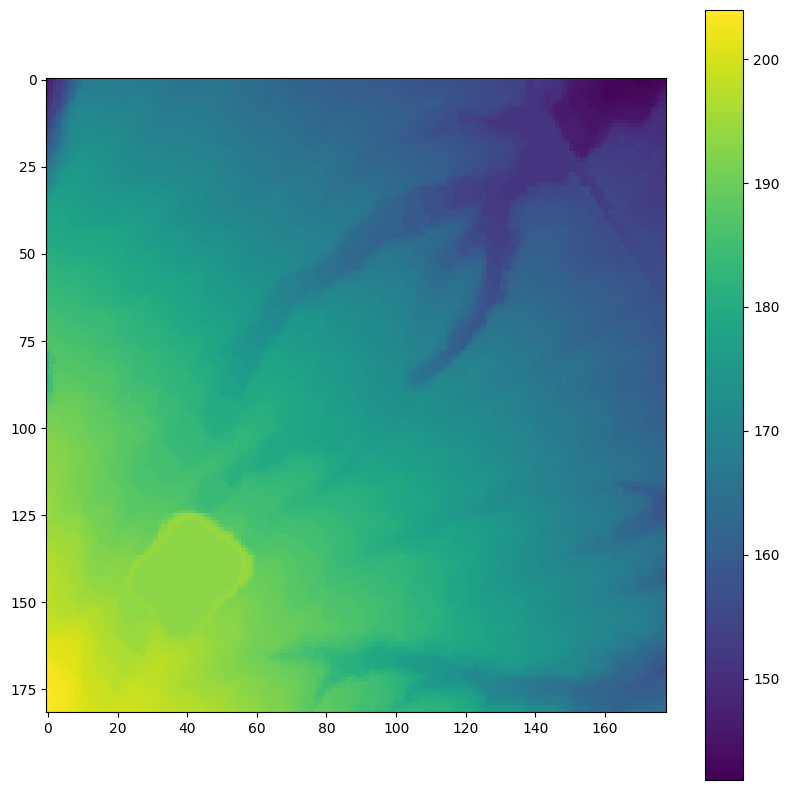

In [893]:
dtm_ds = openf("data/iterator/dtm.tif")
dtm_gt = dtm_ds.GetGeoTransform()
mannings_ds = openf("data/iterator/mannings.tif")
mannings_gt = mannings_ds.GetGeoTransform()

cellsize = (dtm_gt[1] - dtm_gt[5]) / 2
cellarea = math.pow(cellsize, 2)

dtm = rd.rdarray(as_array(dtm_ds), no_data=NAN)
rd.FillDepressions(dtm, in_place=True)

mannings = GeoTransformFit(np.array(as_array(mannings_ds)), mannings_gt, dtm_gt)

plt.figure(figsize=(10, 10))
plt.imshow(dtm)
plt.colorbar()

In [894]:
floods = np.zeros(dtm.shape)
drafts = np.zeros(dtm.shape)
speeds = np.zeros(dtm.shape)
drainages = np.zeros(dtm.shape)
                  
source = get_rowcol(*COORDS, ds=dtm_ds)
overcomes = {source: True}
start, slope = start_point(source)

hyd = gen_hydrogram(HYDROGRAM)
break_flood = 0
while drafts[start] < 1:
    break_flood = next(hyd)    
    floods[start] = break_flood
    drafts[start] = get_draft(break_flood)
    speeds[start] = get_speed(drafts[start], mannings[start], get_slope(get_slopes(rc)))

i = 0
last_flood = break_flood
flood = break_flood
distance = 0
trapped = 0
next_step = {start: True}

## Starts loop

In [1155]:
print("Flood: ", flood)
print("Next step: ", len(list(next_step.keys())))

Flood:  31.666666666666668
Next step:  2446


In [1156]:
next_step, catchments = drainpaths(next_step, {}, {}, 1, [], {})

Level:  1
Level:  2
Level:  3
Level:  4
Level:  5
Level:  6
Level:  7
Level:  8


In [1157]:
try:
    flood = next(hyd)
    flood_factor = flood / last_flood
except (ZeroDivisionError, StopIteration):
    print("Exit condition: Hydrogram drained")
    
for rc in catchments:
    catchment = max(0, catchments[rc]) * flood_factor
    if catchment <= 0:
        continue
    floods[rc] += catchment
    drafts[rc] = get_draft(catchment)
    slope = get_slope(get_slopes(rc))
    speeds[rc] = get_speed(drafts[rc], mannings[rc], slope)
    drainages[rc] += 1

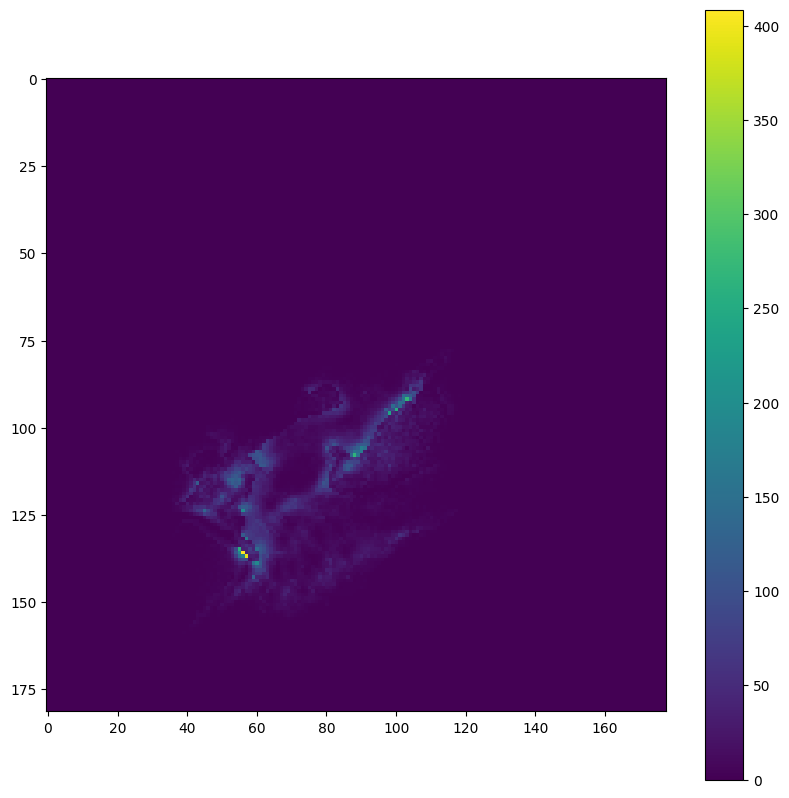

In [1158]:
plt.figure(figsize=(10, 10))
plt.imshow(floods)
plt.colorbar()

In [1154]:
edge = np.sqrt(np.power(abs(np.argwhere(floods > 0) - start) * cellsize, 2).sum(1)).max()
if distance == int(edge):
    trapped += 1
else:
    trapped = 0

distance = int(edge)
last_flood = flood
i += 1

if i > 1e+4:
    print("\nExit condition: Max recursion limit")
elif trapped >= 5e+3:
    print("\nExit condition: Flood's stability reached")
elif distance >= 2000:
    print("\nExit condition: Distance limit reached")

[Loop's step forward](#Starts-loop)

In [888]:
next_step

{(129, 52): True,
 (151, 55): True,
 (152, 76): True,
 (149, 83): True,
 (100, 66): True,
 (100, 67): True,
 (150, 79): True,
 (151, 79): True,
 (154, 72): True,
 (152, 77): True,
 (152, 78): True,
 (155, 62): True,
 (156, 66): True,
 (96, 71): True,
 (96, 72): True,
 (96, 73): True,
 (99, 67): True,
 (99, 68): True,
 (98, 68): True,
 (128, 50): True,
 (102, 62): True,
 (101, 63): True,
 (101, 64): True,
 (128, 49): True,
 (153, 59): True,
 (154, 59): True,
 (154, 61): True,
 (155, 63): True,
 (154, 60): True,
 (155, 60): True,
 (155, 61): True,
 (153, 57): True,
 (153, 58): True,
 (154, 57): True,
 (154, 58): True,
 (155, 71): True,
 (155, 72): True,
 (154, 73): True,
 (155, 73): True,
 (154, 74): True,
 (155, 74): True,
 (140, 94): True,
 (94, 75): True,
 (94, 76): True,
 (93, 76): True,
 (93, 77): True,
 (94, 78): True,
 (97, 70): True,
 (137, 98): True,
 (138, 97): True,
 (138, 98): True,
 (137, 99): True,
 (138, 99): True,
 (136, 100): True,
 (137, 100): True,
 (138, 100): True,
 